# Universal Gap function for use with L01, CU SIM and L2D 
## Overall goal

The overall goal here is to provide a simple and easy to use code that generates a masking function mimicking our best understanding of missing data with respect to LISA. 

## What does the code do? 

The code takes in a dictionary of planned and unplanned gaps with their specific types, rates per year and duration in hours. It can then produce a binary mask

$$
 w(t) = 1 \ \text{if} \ t \not \in T_{\text{gap}} \  \text{and} \  w(t) = \boldsymbol{\text{nan}} \  \text{if} \  t \in T_{\text{gap}}\,.
 $$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from lisagap import GapMaskGenerator
from lisaconstants import TROPICALYEAR_J2000DAY

%reload_ext autoreload
%autoreload 2


Usable data
Duty cyle is = 90.5473681205097 %


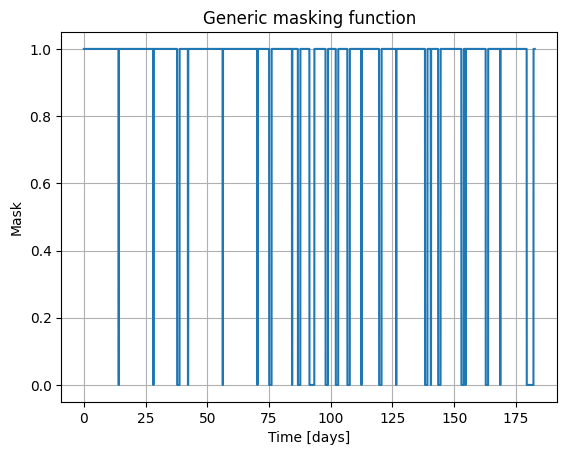

In [4]:

# Set up simulation properties
A_YEAR = TROPICALYEAR_J2000DAY * 86400  # seconds in a year
dt = 0.25  # seconds
t_start = 0 # start time in seconds
t_obs = 0.5*A_YEAR
sim_t = t_start + np.arange(0,t_obs, dt) # time array

planseed = 2618240388
unplanseed = 3387490715

# Build dictionary of gap definitions, planned and unplanned. We must 
# supply both of these, even if the rates are zero and durations are zero. 
# We can cope with arbitrary number of gaps.
gap_definitions = {
    "planned": {
        "antenna repointing": {"rate_per_year": 26, "duration_hr": 3.3},
        "TM stray potential": {"rate_per_year": 2, "duration_hr": 24},
        "TTL calibration": {"rate_per_year": 4, "duration_hr": 48},
        #"Aliens": {"rate_per_year": 6, "duration_hr": 30*24}
    },
    "unplanned": {
        "platform safe mode": {"rate_per_year": 3, "duration_hr": 60},
        "payload safe mode": {"rate_per_year": 4, "duration_hr": 66},
        "QPD loss micrometeoroid": {"rate_per_year": 5, "duration_hr": 24},
        "HR GRS loss micrometeoroid": {"rate_per_year": 19, "duration_hr": 24},
        "WR GRS loss micrometeoroid": {"rate_per_year": 6, "duration_hr": 24},
    }
}

# Initialise the class with simulation properties and whether or not to treat gaps with
# nans or not. 
gap_mask_gen = GapMaskGenerator(sim_t, 
                                dt, 
                                gap_definitions, 
                                treat_as_nan = False, 
                                planseed = planseed,
                                unplanseed = unplanseed)

# Generate the mask as a np.array. Choose whether to include unplanned and/or planned gaps.
# num_zeros = np.sum(full_mask == 0)/len(full_mask)
full_mask = gap_mask_gen.generate_mask(include_unplanned=True, include_planned=True)
num_zeros = np.sum(full_mask == 0)/len(full_mask)
print("Usable data")
print(f"Duty cyle is = {100*(1-num_zeros)} %")

plt.plot(sim_t/60/60/24,full_mask)
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title(r'Generic masking function')
plt.grid()

## Some extra utilities

It is possible to save the masking function as a `.h5` file. Similarly, we can load the `.h5` file as a class object and generate the masking function.  

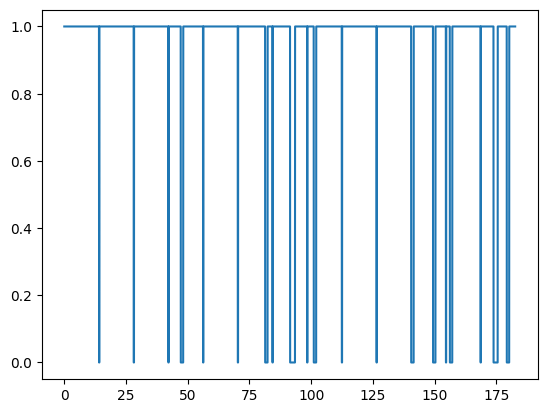

In [6]:
# Save the masking function to a hdf5 file. 
gap_mask_gen.save_to_hdf5(full_mask, filename = "gap_mask_data.h5")

# Load the masking function to a hdf5 file. Note that we do not need to instantiate the class. 
# This will load in the masking function and all important attributes. 
load_gating_func = GapMaskGenerator.from_hdf5(filename = "gap_mask_data.h5")
plt.plot(sim_t/60/60/24, load_gating_func.generate_mask(include_unplanned=True, include_planned=True))

## Generate summary of gap configuration

We can easily generate a summary of the gap configuration using one of the functions in the class method. 

In [7]:
check = gap_mask_gen.summary(mask = full_mask, export_json_path="gap_mask_summary.json")
from pprint import pprint
pprint(check)

{'computation': {'gpu_available': False, 'use_gpu': False},
 'mask_analysis': {'duty_cycle_percent': np.float64(90.5474),
                   'number_of_gap_segments': 24,
                   'total_gap_hours': np.float64(414.3),
                   'total_gap_samples': 5965920},
 'planned_gaps': {'TM stray potential': {'duration_hr': 24,
                                         'duration_samples': 345600,
                                         'duration_sec': 86400,
                                         'rate_events_per_sec': 6.33775307356206e-08,
                                         'rate_events_per_year': 2},
                  'TTL calibration': {'duration_hr': 48,
                                      'duration_samples': 691200,
                                      'duration_sec': 172800,
                                      'rate_events_per_sec': 1.267550614712412e-07,
                                      'rate_events_per_year': 4},
                  'antenna repointing':

# Smooth tapers

So far the gap function generates a binary mask with eithers zeros or *nans* representing the gaps. For those within L2D, it may be preferable to smoothly taper the gap segments to zeros in order to reduce artefacts working in the frequency or time-frequency domains. 

To facilitate this, we have taken the binary mask and applied a smooth taper on either side of each gap with the "length of the lobes" provided as input. An example is given below 

In [8]:
# Define the length of the tapering window on each side of the gap. Must input lobe lengths in hours. 

# If we miss out a particular gap definition, it will not be tapered. 

taper_defs = {
    "planned": {
        "antenna repointing": {"lobe_lengths_hr": 5.0},
        "TM stray potential": {"lobe_lengths_hr": 0.5},
        "TTL calibration": {"lobe_lengths_hr": 2.0}},
        # "Aliens": {"lobe_lengths_hr" : 1 * 24}},
    "unplanned": {
        "platform safe mode": {"lobe_lengths_hr": 1.0},
        "HR GRS loss micrometeoroid": {"lobe_lengths_hr": 0.25},
        "QPD loss micrometeoroid": {"lobe_lengths_hr":1.0},
        "HR GRS loss micrometeoroid": {"lobe_lengths_hr":7.0},
        "WR GRS loss micrometeoroid": {"lobe_lengths_hr":10.0}
    }
}

smoothed_mask = gap_mask_gen.apply_smooth_taper_to_mask(full_mask, taper_gap_definitions=taper_defs)

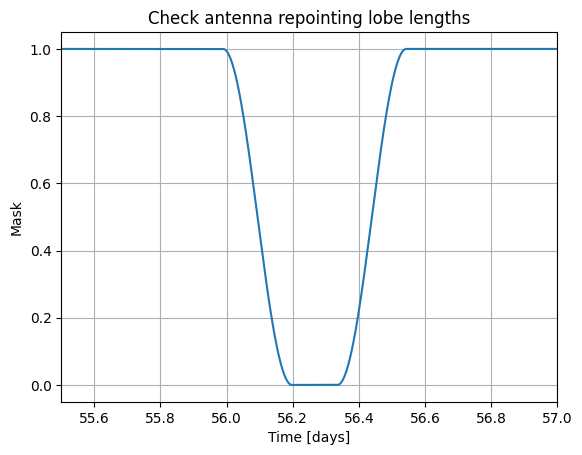

In [9]:
plt.plot(sim_t/60/60/24,smoothed_mask)
plt.xlim([55.5,57])
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title(r'Check antenna repointing lobe lengths')
plt.grid()


# Build quality masking data set with flags 

We can also use this class to build a masking function based off the nature of a data set. If a np.array is fed into a particular functino of the class, it can be read in and a further array with 1s for valid data and nans for invalid data can be produced

Duty cycle =  90.54736812050972 %


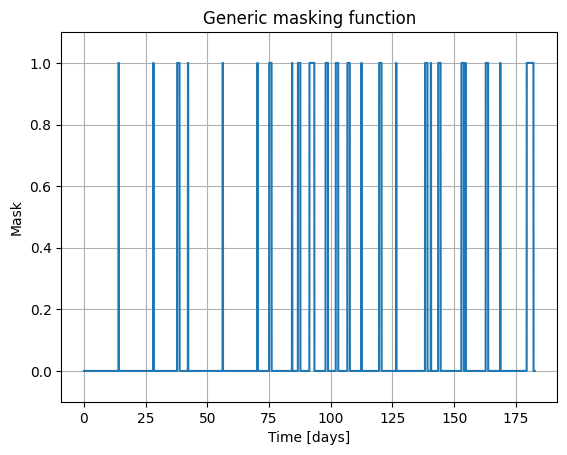

In [10]:
gap_mask_gen_w_nans = GapMaskGenerator(sim_t, 
                                       dt, 
                                       gap_definitions, 
                                       planseed = 2618240388,
                                       unplanseed = 3387490715,
                                       treat_as_nan = True)

# Generate the mask as a np.array. Choose whether to include unplanned and/or planned gaps.
full_mask_w_nans = gap_mask_gen_w_nans.generate_mask(include_unplanned=True, include_planned=True)


# Build the quality flags. 
build_quality_flags = gap_mask_gen.build_quality_flags(full_mask_w_nans)
plt.plot(sim_t/60/60/24,build_quality_flags)
plt.ylim([-0.1,1.1])
plt.xlabel(r'Time [days]')
plt.ylabel(r'Mask')
plt.title(r'Generic masking function')
plt.grid()
# Check, what is the overall duty cycle?

duty_cycle = 100*(len(build_quality_flags) - np.sum(build_quality_flags))/len(build_quality_flags)
print("Duty cycle = ", duty_cycle, "%")
